In [1]:
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from IPython.display import display_html
from sklearn.utils import estimator_html_repr

from dbpedia_common import DataFrameRepository, get_single_stratified_split
from anomalies_analyser import compare_population_with_web
from models import get_lxgb_pipeline, ModelEvaluator

%matplotlib inline
train_df = DataFrameRepository(version='last').get()

In [2]:
display_html(estimator_html_repr(get_lxgb_pipeline()), raw=True)

Pipeline Pipeline(steps=[('calculated_pop', CalculatedPopTransformer()),
 ('categorical_transformer',
 Pipeline(steps=[('set_as_category',
 FunctionTransformer(func= .set_as_category at 0x7f4b6bd77dd0>))])),
 ('rename_columns',
 Pipeline(steps=[('rename_columns',
 FunctionTransformer(func= .rename_cols at 0x7f4b6b5985f0>))])),
 ('model',
 LGBMRegressor(bagging_freq=20, cat_smooth=1,
 feature_fraction=0.3, learning_rate=0.02,
 max_depth=7, n_estimators=3000, num_leaves=25,
 reg_alpha=0.8))]) CalculatedPopTransformer CalculatedPopTransformer() categorical_transformer: Pipeline Pipeline(steps=[('set_as_category',
 FunctionTransformer(func= .set_as_category at 0x7f4b6bd77dd0>))]) FunctionTransformer FunctionTransformer(func= .set_as_category at 0x7f4b6bd77dd0>) rename_columns: Pipeline Pipeline(steps=[('rename_columns',
 FunctionTransformer(func= .rename_cols at 0x7f4b6b5985f0>))]) FunctionTransformer FunctionTransformer(func= .rename_cols at 0x7f4b6b5985f0>) LGBMRegressor LGBMRegressor(bagging_freq=20, cat_smooth=1, feature_fraction=0.3,
 learning_rate=0.02, max_depth=7, n_estimators=3000, num_leaves=25,
 reg_alpha=0.8)

********************
Test RMSLE: 0.2662224440089942
Test RMSE: 264258.3455709627
********************
Train RMSLE: 0.24083669890391082
Train RMSE: 211668.3558106377


,pretty_subject,log_diff,log_target,log_predicted,target,predicted,diff,subject
21620,"Meads,_Kentucky>",-2.045,5.460,3.415,288649.000,2601.757,-286047.243,"<http://dbpedia.org/resource/Meads,_Kentucky>"
29582,Rutog_Town>,1.562,3.000,4.562,1000.000,36434.683,35434.683,<http://dbpedia.org/resource/Rutog_Town>
18243,Kungsholmen_(borough)>,-1.413,4.833,3.420,68016.000,2629.554,-65386.446,<http://dbpedia.org/resource/Kungsholmen_(boro...
1926,Ba'a>,1.407,3.065,4.472,1161.000,29615.090,28454.090,<http://dbpedia.org/resource/Ba'a>
26787,Pibor>,1.377,3.000,4.377,1000.000,23841.610,22841.610,<http://dbpedia.org/resource/Pibor>
...,...,...,...,...,...,...,...,...
11322,"Forrest,_Illinois>",-0.000,3.086,3.086,1220.000,1219.738,-0.262,"<http://dbpedia.org/resource/Forrest,_Illinois>"
30074,Samtens>,0.000,3.320,3.320,2087.000,2087.299,0.299,<http://dbpedia.org/resource/Samtens>
33861,Sösdala>,-0.000,3.258,3.258,1811.000,1810.819,-0.181,<http://dbpedia.org/resource/Sösdala>
30968,"Sayat-Nova,_Armenia>",0.000,3.273,3.273,1875.000,1875.122,0.122,"<http://dbpedia.org/resource/Sayat-Nova,_Armenia>"


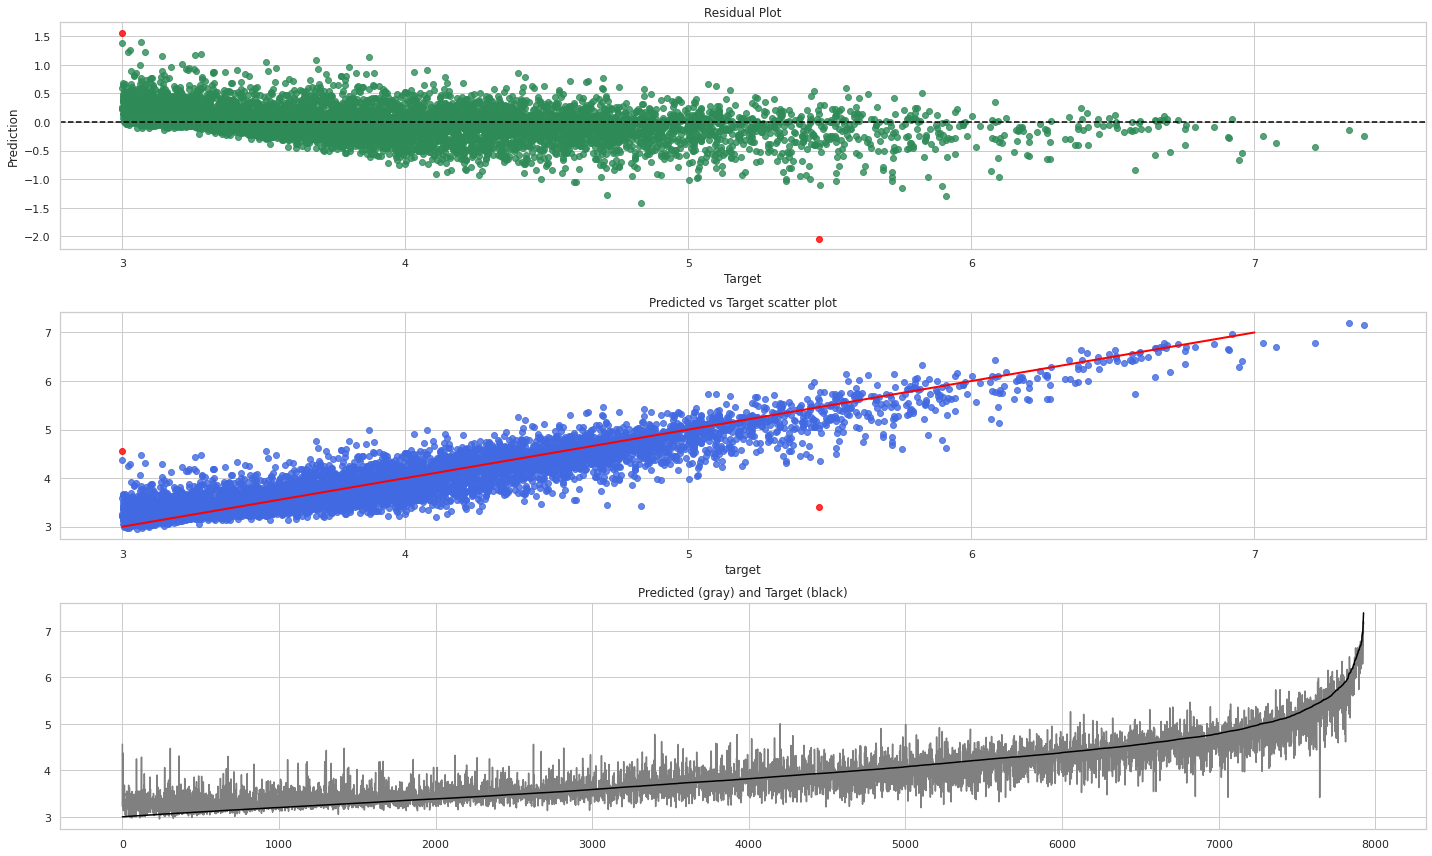

In [2]:
train_index, test_index = get_single_stratified_split(train_df)

X = train_df.drop(columns=['subject', 'target'])
y = np.log10(train_df.target)


X_train, y_train = X.loc[train_index], y.loc[train_index]
y_test = y.loc[test_index].sort_values()
X_test = X.loc[test_index].reindex(y_test.index)


model = TransformedTargetRegressor(regressor=get_lxgb_pipeline(), transformer=MinMaxScaler())
model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=False)
evaluator.plot_results()
error_analysis_df = evaluator.get_error_analysis(train_df)
error_analysis_df

In [3]:
compare_population_with_web(error_analysis_df, limit=10).head(10)

0 Errors found while parsing wikipedia webpage. Make a manual check for: []
There are 0 suspicious subjects! Check if found values are real and fix the records


,pretty_subject,error,expected_value,found_value,relative_log_diff,message,wiki_link,subject
0,"Meads,_Kentucky",False,288649.000,288649,0.000,,https://en.wikipedia.org/wiki/Meads%2C_Kentucky,"<http://dbpedia.org/resource/Meads,_Kentucky>"
1,Rutog_Town,False,1000.000,1000,0.000,,https://en.wikipedia.org/wiki/Rutog_Town,<http://dbpedia.org/resource/Rutog_Town>
2,Kungsholmen_(borough),False,68016.000,68016,0.000,,https://en.wikipedia.org/wiki/Kungsholmen_%28b...,<http://dbpedia.org/resource/Kungsholmen_(boro...
3,Ba'a,False,1161.000,1161,0.000,,https://en.wikipedia.org/wiki/Ba%27a,<http://dbpedia.org/resource/Ba'a>
4,Pibor,False,1000.000,1000,0.000,,https://en.wikipedia.org/wiki/Pibor,<http://dbpedia.org/resource/Pibor>
5,Narela,False,809913.000,809913,0.000,,https://en.wikipedia.org/wiki/Narela,<http://dbpedia.org/resource/Narela>
6,"Bret_Harte,_California",False,51481.000,51481,0.000,,https://en.wikipedia.org/wiki/Bret_Harte%2C_Ca...,"<http://dbpedia.org/resource/Bret_Harte,_Calif..."
7,"The_Valley,_Anguilla",False,1067.000,1067,0.000,,https://en.wikipedia.org/wiki/The_Valley%2C_An...,"<http://dbpedia.org/resource/The_Valley,_Angui..."
8,San_Carlos_de_Río_Negro,False,1200.000,1200,0.000,,https://en.wikipedia.org/wiki/San_Carlos_de_R%...,<http://dbpedia.org/resource/San_Carlos_de_Río...
9,"Hagåtña,_Guam",False,1051.000,1051,0.000,,https://en.wikipedia.org/wiki/Hag%C3%A5t%C3%B1...,"<http://dbpedia.org/resource/Hagåtña,_Guam>"


### Trying splitting target in bins

In [72]:
df = train_df.copy()
bins = [0,2499, 4999, 9999, 49999, 99999, 499_999, 999_999, np.inf]
label_bins = [0, 1, 2 ,3, 4, 5, 6, 7]
df['target'] = pd.cut(df['target'], bins=bins, labels=label_bins).astype(int)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_index, test_index = next(split.split(df, df['target']))

X = train_df.drop(columns=['subject', 'target'])
y = np.log10(train_df.target)

X_train, y_train = X.loc[train_index], y.loc[train_index]
y_test = y.loc[test_index]
X_test = X.loc[test_index]

model = TransformedTargetRegressor(regressor=get_lxgb_pipeline(), transformer=MinMaxScaler())
model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(log=False)

r = pd.cut(10**test_pred, bins=bins, labels=label_bins).astype(int)

y_test_r=pd.cut(10**y_test, bins=bins, labels=label_bins).astype(int)

print(f'Quadratic Kappa Score: {cohen_kappa_score(y_test_r, r, weights="quadratic")}')
confusion_matrix(y_test_r, r, labels=label_bins)

Quadratic Kappa Score: 0.8866730566276324


array([[1985,  947,  150,   34,    1,    0,    0,    0],
       [ 359, 1347,  352,   81,    2,    1,    0,    0],
       [  65,  541,  888,  325,    5,    2,    0,    0],
       [   6,  189,  487, 2274,  173,   22,    0,    0],
       [   0,    3,   11,  299,  292,   68,    1,    0],
       [   0,    0,    4,   87,  162,  417,   33,    5],
       [   0,    0,    0,    1,    4,   61,   42,   15],
       [   0,    0,    0,    1,    0,   12,   30,  105]])